# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

In [56]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import datetime
import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

In [2]:
def calc_avg_degree(graph):
    sum_of_edges = sum(deg for n, deg in graph.degree())
    k = sum_of_edges / graph.number_of_nodes()
    return k

def implied_beta(k, r):
    """ Formula: r = k * beta, so beta equals r/k.
    """
    return r / k

def scale_free_graph(num_nodes, alpha=2.3):
    """ Generate the scale free graph with the degree sequence specified
        by the power law distribution parameterized by alpha. 
    """
    int_seq = np.zeros(num_nodes).astype(int)
    idx = 0
    while idx < num_nodes:
        nextval = int(nx.utils.powerlaw_sequence(1, alpha)[0])
        if idx == num_nodes - 1 and (int_seq.sum() + nextval) % 2 != 0 : # make sure sum is even
            continue
        if nextval > 10 and nextval < 1e6:
            int_seq[idx] = nextval
            idx += 1
    # can't use trecs.SocialGraphGenerator because "n" is not an argument to configuration_model
    # remove self-loops and duplicate edges
    G = nx.configuration_model(int_seq) 
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [3]:
G = scale_free_graph(1000, alpha=2.3)
k = calc_avg_degree(G)
print(f"Average degree (k): {k}")
r = 0.5 # if r = 0.5, what is the beta implied?
print(f"Implied infectiousness when r={r}: {implied_beta(k,r)}")

Average degree (k): 29.64
Implied infectiousness when r=0.5: 0.016869095816464237


Text(0.5, 1.0, 'Frequency of degree for nodes in scale-free network')

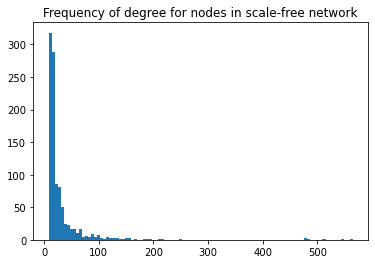

In [4]:
# plot degrees of nodes
degrees = [deg for n, deg in G.degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of degree for nodes in scale-free network")

In [5]:
def setup_experiment(num_nodes, r=0.5, alpha=2.3):
    G = scale_free_graph(num_nodes, alpha=alpha)
    user_rep = nx.convert_matrix.to_numpy_array(G) # convert to numpy adjacency matrix
    # calculate required item infectiousness
    k = calc_avg_degree(G)
    beta = implied_beta(k, r)
    item_rep = np.array([[beta]]) # must be two dimensional
    
    # seed infection with 1 user
    infection_state = np.zeros(user_rep.shape[0]).reshape(-1, 1) # must be two dimensional array
    seed_user = np.random.choice(num_nodes, 1)
    infection_state[seed_user, 0] = 1
    
    # create model
    bass = BassModel(
        user_representation=user_rep,
        item_representation=item_rep,
        infection_state=infection_state
    )
    return bass

In [99]:
# calculate metrics of interest
def popularity(simulation):
    return (simulation.infection_state != 0).sum()

def graph_popularity(sizes):
    plt.hist(sizes, bins=100)
    plt.title("Frequency of cascade sizes")
    plt.xlabel("Size")
    plt.ylabel("Frequency")
    
def prob_large_cascade(sizes):
    large_cascades = np.where(sizes > 100)[0]
    return len(large_cascades) / len(sizes)

def mean_virality(viralitys):
    # Assume virality of -1 are invalid trials
    # (i.e., the seed user was not able to infect)
    # any other user
    return viralitys[viralitys > -1].mean()

def size_virality_corr(sizes, viralitys):
    """ Calculate correlation between size of cascade
        and structural virality of cascade. Only compute
        correlation on trials where >1 node was infected
        (and therefore structural virality is computable.)
    """
    valid_sims = viralitys > -1 
    stacked_obvs = np.vstack([sizes[valid_sims], viralitys[valid_sims]])
    return np.corrcoef(stacked_obvs)[0, 1]

# Run simulation with 10k users

In [59]:
# test bass model
num_users = 10000
num_trials = 2500

sizes = np.zeros(num_trials)
viralitys = np.zeros(num_trials)


for i in range(num_trials):
    if i % 50 == 0:
        print(f"On trial {i} at time {datetime.datetime.now()}...")
    simulation = setup_experiment(num_users)
    simulation.run()
    size = popularity(simulation)
    sizes[i] = size
    try:
        sv = simulation.get_structural_virality()
        viralitys[i] = sv
    except:
        viralitys[i] = -1 # couldn't calculate virality


On trial 0 at time 2021-01-29 00:58:06.798617...
On trial 50 at time 2021-01-29 01:06:45.377071...
On trial 100 at time 2021-01-29 01:16:00.822602...
On trial 150 at time 2021-01-29 01:24:04.789807...
On trial 200 at time 2021-01-29 01:32:01.431891...
On trial 250 at time 2021-01-29 01:39:45.805835...
On trial 300 at time 2021-01-29 01:47:49.459406...
On trial 350 at time 2021-01-29 01:55:49.965719...
On trial 400 at time 2021-01-29 02:04:05.288979...
On trial 450 at time 2021-01-29 02:12:15.020977...
On trial 500 at time 2021-01-29 02:20:15.731889...
On trial 550 at time 2021-01-29 02:28:14.466123...
On trial 600 at time 2021-01-29 02:36:49.518257...
On trial 650 at time 2021-01-29 02:45:08.259642...
On trial 700 at time 2021-01-29 02:53:14.229321...
On trial 750 at time 2021-01-29 03:01:38.875938...
On trial 800 at time 2021-01-29 03:10:04.488411...
On trial 850 at time 2021-01-29 03:18:12.005204...
On trial 900 at time 2021-01-29 03:26:27.562315...
On trial 950 at time 2021-01-29 03

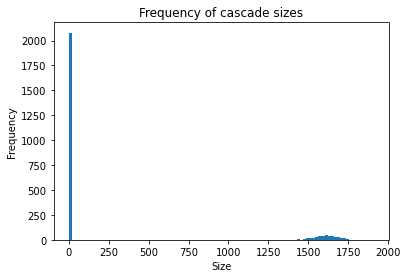

In [94]:
graph_popularity(sizes)

In [102]:
print(f"Probability of a large cascade: {prob_large_cascade(sizes)}")
print(f"Mean structural virality: {mean_virality(viralitys)}")
print(f"Correlation between popularity and structural virality: {size_virality_corr(sizes, viralitys)}")

Probability of a large cascade: 0.1676
Mean structural virality: 3.3284972630922685
Correlation between popularity and structural virality: 0.9673114499638322
